In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from coffea import hist
from coffea.processor import defaultdict_accumulator

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
hep.style.use("CMS")
#hep.CMS.text("Phase 2 Simulation")


import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

# #line thickness
# import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

2023-04-02 10:21:05.747670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 10:21:05.947316: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-02 10:21:05.947353: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-02 10:21:10.359098: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Double Tau Rate Plot

Scanning both pT and NN score.

* Denominator: no cuts.
* Numerator: $|\eta| < 2.172$, $\Delta R > 0.5$

There is no need to slice the data since the model is trained on single tau sample and used for prediction on the Di Tau sample.

In [ ]:
ModelName = '../../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5'
TreeName = 'ntuplePupDiTau'

In [1]:
sig = True

In [ ]:
if sig:
    data_path = "../ntuples/Jan_25_2023/test_sig_v11.root"
else:
    data_path = "../ntuples/Jan_25_2023/test_bkg_v11.root"

data = uproot4.open(data_path)

data_id, data_idx = np.unique(np.asarray(data[TreeName]['tree']['event'].array()), return_index=True)



In [ ]:
model = load_model(ModelName)

#Filter out the test signals
sig = uproot4.open("../ntuples/Jan_25_2023/test_sig_v11.root")
bkg = uproot4.open("../ntuples/Jan_25_2023/test_bkg_v11.root")

#Pickout unique events
_, bkg_idx = np.unique(np.asarray(bkg[TreeName]['tree']['event'].array()), return_index=True)
_, sig_idx = np.unique(np.asarray(bkg[TreeName]['tree']['event'].array()), return_index=True)



In [ ]:
def get_id_and_score(sig = True):
    
    if sig:
        data_path = "../ntuples/Jan_25_2023/test_sig_v11.root"
    else:
        data_path = "../ntuples/Jan_25_2023/test_bkg_v11.root"
    
    data = uproot4.open(data_path)
    
    return data_id, tau_score

In [ ]:
truth_sig_pt_cut = 20.

#Filter out the test signals
sig = uproot4.open("../ntuples/Jan_25_2023/test_sig_v11.root")
bkg = uproot4.open("../ntuples/Jan_25_2023/test_bkg_v11.root")

unique_bkg_event = np.unique(np.asarray(bkg['ntuplePupSingle']['tree']['event'].array()))
unique_sig_event = np.unique(np.asarray(sig['ntuplePupSingle']['tree']['event'].array())[400000:])

#Load model and select out the tau
model = load_model(model_name)

#Sig
sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[400000:]

truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[400000:]
reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[400000:]
truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[400000:]
truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[400000:]
selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[400000:][selection_sig])

X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
X_sig[abs(X_sig) > 1e+4] = 0.
y_sig = model.predict(X_sig)
#y_sig = score_transform_new(y_sig_model.flatten(), np.asarray(reco_pt_sig[selection_sig]).flatten())

#Bkg
bkg_input = np.asarray(bkg['ntuplePupSingle']['tree']['m_inputs'].array()[400000:])
bkg_id = np.asarray(bkg['ntuplePupSingle']['tree']['event'].array()[400000:])
bkg_pt = np.asarray(bkg['ntuplePupSingle']['tree']['pt'].array()[400000:]) 
selection_bkg = bkg_pt > 20
bkg_id_pt = bkg_id[selection_bkg]

total_n_minbias = np.unique(bkg_id).shape[0]
total_n_sig = np.intersect1d(np.unique(bkg_id), np.unique(sig_id)).shape[0]

bkg_input[abs(bkg_input) > 1e+4] = 0.
y_bkg = model.predict(bkg_input[selection_bkg])
#y_bkg = score_transform_new(y_bkg_model.flatten(), bkg_pt[selection_bkg].flatten())

In [ ]:
model = load_model(ModelName)
    
#Load the data
MinBias = uproot4.open("../../ntuples/Jan_25_2023/test_bkg_v11.root")

#Pick out unique events
_, bkg_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()), return_index=True)

#Impose the eta and deltaR requirements
eta1 = np.asarray(MinBias[TreeName]['tree']['eta1'].array())[bkg_index]
eta2 = np.asarray(MinBias[TreeName]['tree']['eta2'].array())[bkg_index]

phi1 = np.asarray(MinBias[TreeName]['tree']['phi1'].array())[bkg_index]
phi2 = np.asarray(MinBias[TreeName]['tree']['phi2'].array())[bkg_index]

d_eta = eta1 - eta2
d_phi = phi1 - phi2
d_R = np.sqrt(d_eta**2 + d_phi**2)

eta_select = (np.abs(eta1) < 2.172) & (np.abs(eta2) < 2.172)
all_select = eta_select & (d_R > 0.5)

n_event = bkg_index[all_select].shape[0]

pt1 = np.asarray(MinBias[TreeName]['tree']['pt1'].array())[bkg_index][all_select]
pt2 = np.asarray(MinBias[TreeName]['tree']['pt2'].array())[bkg_index][all_select]

input1 = np.nan_to_num(np.asarray(MinBias[TreeName]['tree']['m1_inputs'].array())[bkg_index])[all_select]
input2 = np.nan_to_num(np.asarray(MinBias[TreeName]['tree']['m2_inputs'].array())[bkg_index])[all_select]

pt = np.vstack([pt1, pt2]).transpose()
pt_min = np.min(pt, axis=1)

#Get the NN score
score1 = model.predict(input1).flatten()
score2 = model.predict(input2).flatten()

#Put them together
NN_score = np.vstack([score1, score2]).transpose()
NN_score_min = np.min(NN_score, axis=1)

In [4]:
def plot_DTau_rate(ModelName, TreeName='ntuplePupDiTau'):
    
    model = load_model(ModelName)
    
    #Load the data
    MinBias = uproot4.open("../../ntuples/Jan_25_2023/test_bkg_v11.root")
    
    #Pick out unique events
    _, bkg_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()), return_index=True)
    
    #Impose the eta and deltaR requirements
    eta1 = np.asarray(MinBias[TreeName]['tree']['eta1'].array())[bkg_index]
    eta2 = np.asarray(MinBias[TreeName]['tree']['eta2'].array())[bkg_index]
    
    phi1 = np.asarray(MinBias[TreeName]['tree']['phi1'].array())[bkg_index]
    phi2 = np.asarray(MinBias[TreeName]['tree']['phi2'].array())[bkg_index]
    
    d_eta = eta1 - eta2
    d_phi = phi1 - phi2
    d_R = np.sqrt(d_eta**2 + d_phi**2)
    
    eta_select = (np.abs(eta1) < 2.172) & (np.abs(eta2) < 2.172)
    all_select = eta_select & (d_R > 0.5)
    
    n_event = bkg_index[all_select].shape[0]
    
    pt1 = np.asarray(MinBias[TreeName]['tree']['pt1'].array())[bkg_index][all_select]
    pt2 = np.asarray(MinBias[TreeName]['tree']['pt2'].array())[bkg_index][all_select]
    
    input1 = np.nan_to_num(np.asarray(MinBias[TreeName]['tree']['m1_inputs'].array())[bkg_index])[all_select]
    input2 = np.nan_to_num(np.asarray(MinBias[TreeName]['tree']['m2_inputs'].array())[bkg_index])[all_select]
    
    pt = np.vstack([pt1, pt2]).transpose()
    pt_min = np.min(pt, axis=1)
    
    #Get the NN score
    score1 = model.predict(input1).flatten()
    score2 = model.predict(input2).flatten()
    
    #Put them together
    NN_score = np.vstack([score1, score2]).transpose()
    NN_score_min = np.min(NN_score, axis=1)
    
    return n_event, pt_min, NN_score_min
    

In [5]:
n_evt, pt_min, NN_min = plot_DTau_rate('../../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5')

958/958 [==============================] - 2s 2ms/step


In [6]:
#Define the histograms (pT edge and NN Score edge)
pT_edges = list(np.arange(0,100,2)) + [300] #Make sure to capture everything
NN_edges = list([round(i,2) for i in np.arange(0, 1.01, 0.01)])

RateHist = hist.Hist("Counts",
          hist.Bin("pt", "pt", pT_edges),
          hist.Bin("nn", "nn", NN_edges))

RateHist.fill(pt = pt_min, nn = NN_min)

In [7]:
rate_list = []
pt_list = []
nn_list = []

#Loop through the edges and integrate
for pt in pT_edges:
    for NN in NN_edges:
#         print("-------")
#         print("pt", pt)
#         print("nn", NN)
        
        rate = RateHist.integrate('pt', slice(pt,300)).integrate('nn', slice(NN,1.)).values()[()]/n_evt
        rate_list.append(rate*(32e+3))
        
        pt_list.append(pt)
        nn_list.append(NN)

In [16]:
def find_rate(rate_list, target_rate = 11):
    
    RateRange = 0.5 #kHz
    
    idx_list = []
    
    for i in range(len(rate_list)):
        if target_rate-RateRange <= rate_list[i] <= target_rate + RateRange:
            idx_list.append(i)
            
    return idx_list

def plot_rate(rate_list, pt_list, nn_list, target_rate = 11):
    
    fig, ax = plt.subplots()
    im = ax.scatter(nn_list, pt_list, c=rate_list, s=500, marker='s',
                    cmap='Spectral_r',
                    linewidths=0,
                    norm=matplotlib.colors.LogNorm())

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(r'Di-$\tau_h$ rate [kHZ]')

    plt.ylabel(r"Min reco $p_T$ [GeV]")
    plt.xlabel(r"Min NN Score")
    
    plt.xlim([0,0.99])
    plt.ylim([10,100])
    
    #Find the target rate points, plot them and print out some info as well
    target_rate_idx = find_rate(rate_list, target_rate = 11)
    
    legend_count = 0
    for i in target_rate_idx:
        print("Rate: ", rate_list[i])
        print("NN Cut: ", nn_list[i])
        print("pt Cut: ", pt_list[i])
        print("------")
        
        if legend_count == 0:
            plt.scatter(nn_list[i], pt_list[i], s=600, marker='*',
                        color ='firebrick', label = r"$11 \pm 0.5$ kHz")
        else:
            plt.scatter(nn_list[i], pt_list[i], s=600, marker='*',
                        color ='firebrick')
            
        legend_count += 1
    
    plt.legend()
    plt.show()

Rate:  11.486376244085495
NN Cut:  0.92
pt Cut:  16
------
Rate:  11.486376244085495
NN Cut:  0.81
pt Cut:  20
------
Rate:  11.486376244085495
NN Cut:  0.81
pt Cut:  22
------
Rate:  11.486376244085495
NN Cut:  0.79
pt Cut:  30
------
Rate:  11.486376244085495
NN Cut:  0.75
pt Cut:  36
------
Rate:  11.486376244085495
NN Cut:  0.76
pt Cut:  36
------
Rate:  11.486376244085495
NN Cut:  0.77
pt Cut:  36
------
Rate:  11.486376244085495
NN Cut:  0.74
pt Cut:  38
------
Rate:  11.486376244085495
NN Cut:  0.72
pt Cut:  40
------
Rate:  11.486376244085495
NN Cut:  0.71
pt Cut:  42
------
Rate:  11.486376244085495
NN Cut:  0.57
pt Cut:  48
------
Rate:  11.486376244085495
NN Cut:  0.58
pt Cut:  48
------
Rate:  11.486376244085495
NN Cut:  0.59
pt Cut:  48
------
Rate:  11.486376244085495
NN Cut:  0.6
pt Cut:  48
------
Rate:  11.486376244085495
NN Cut:  0.61
pt Cut:  48
------
Rate:  11.486376244085495
NN Cut:  0.62
pt Cut:  48
------
Rate:  11.486376244085495
NN Cut:  0.63
pt Cut:  48
-----

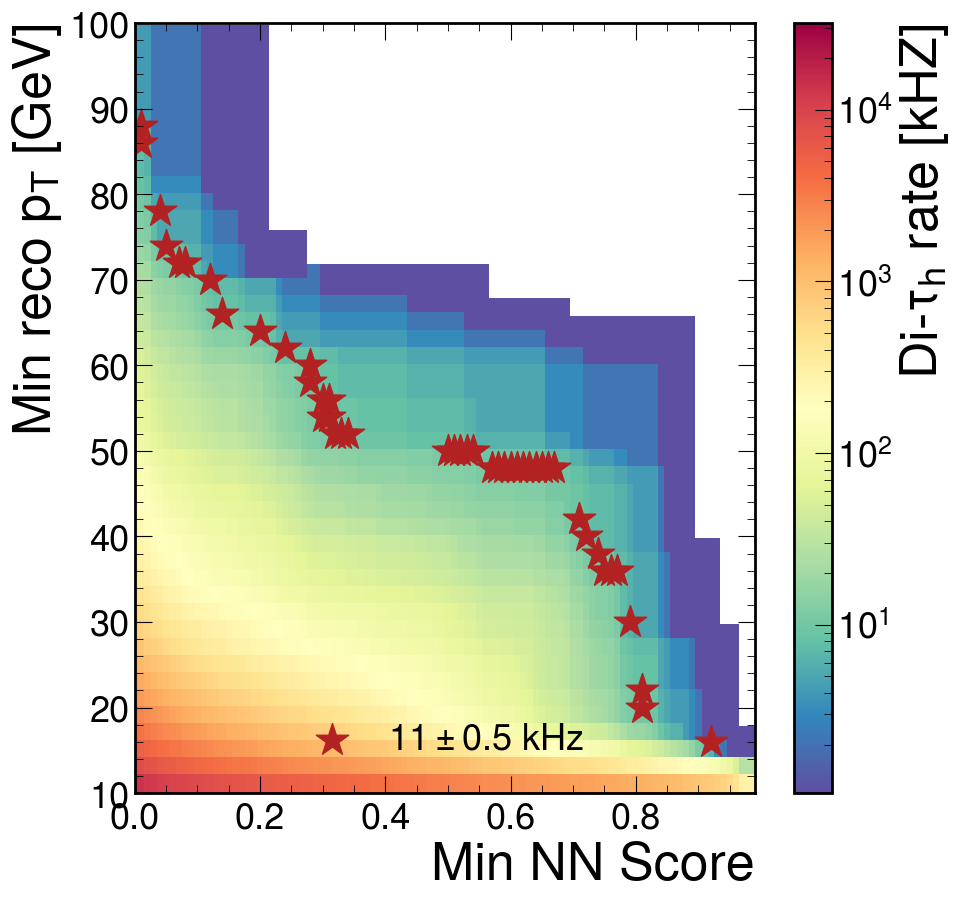

In [17]:
plot_rate(rate_list, pt_list, nn_list)

## Efficiency at the working point

In [7]:
def plot_pt_eff_puppi(ModelName, DataPath, TreeName='ntuplePupSingle', cut_point = 0.05, test_indx=400000):
    
    sig = uproot4.open(DataPath)
    truth_tau_pt = sig[TreeName]['tree']['genpt1'].array()[test_indx:]
    reco_tau_pt = sig[TreeName]['tree']['pt'].array()[test_indx:]

    #Load model and select out the tau
    model = load_model(ModelName)

    #Get all the inputs
    sig_input = sig[TreeName]['tree']['m_inputs'].array()[test_indx:]

    reco_pt_sig = sig[TreeName]['tree']['pt'].array()[test_indx:]
    deltaR_sig = sig[TreeName]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[TreeName]['tree']['geneta1'].array()[test_indx:]

    selection_deno = (truth_tau_pt > 1.) & (abs(eta_sig) < 2.1) #"genpt1 > 1. && abs(geneta1) < 2.1 "
    selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (reco_pt_sig>1.) # " abs(gendr1) < 0.4 && pt > 1."

    #Selected out the tau pt with the basic cuts first
    truth_tau_pt_select = truth_tau_pt[selection_num]
    reco_tau_pt_select = reco_tau_pt[selection_num]
    
    X_sig = np.asarray(sig_input[selection_num])
    y_sig = model.predict(np.nan_to_num(X_sig))
    
    nn_cut = y_sig.flatten() > cut_point
    
    tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

    #Old nn
    old_tau_select = np.asarray(sig[TreeName]['tree']['passLoose'].array()[test_indx:][selection_num])
    tau_pt_old_nn = truth_tau_pt_select[old_tau_select == 1]

    #Fill two plots and divide the two.
    pT_egdes = [0,10,15,20,25,30,35,40,45,50,55,60,70,80,100,125,150] #200?
    pT_axis = hist.axis.Variable(pT_egdes, name = r"$ \tau_h$ $p_T^{gen}$")

    hist_all_tau = Hist(pT_axis)
    hist_selected_puppi = Hist(pT_axis)
    hist_selected_tau = Hist(pT_axis)
    hist_selected_old_tau = Hist(pT_axis)

    hist_all_tau.fill(truth_tau_pt[selection_deno])
    hist_selected_puppi.fill(truth_tau_pt_select)
    hist_selected_tau.fill(tau_pt_nn)
    hist_selected_old_tau.fill(tau_pt_old_nn)
    
    
    fig = plt.figure(figsize=(10, 12))
    main_ax_artists, eff_new_nn_artists = hist_selected_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (New NN Score > 0.05)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    plt.show()
    
    fig = plt.figure(figsize=(10, 12))
    _, eff_old_nn_artists = hist_selected_old_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (Old NN)",
        rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    plt.show()
    
    fig = plt.figure(figsize=(10, 12))
    _, eff_puppi_artists = hist_selected_puppi.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (PUPPI)",
        rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    plt.show()
    
    
    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_err = eff_new_nn_artists.bar.datavalues

    eff_old_nn_x = [eff_old_nn_artists.bar.patches[i].get_x() for i in range(len(eff_old_nn_artists.bar.patches))]
    eff_old_nn_y = [eff_old_nn_artists.bar.patches[i].get_y() for i in range(len(eff_old_nn_artists.bar.patches))]
    eff_old_nn_err = eff_old_nn_artists.bar.datavalues
    
    eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_err = eff_puppi_artists.bar.datavalues

    plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err, fmt='o', label = 'Retrained Tau NN (> 0.05)')
    plt.errorbar(eff_old_nn_x, eff_old_nn_y, yerr=eff_old_nn_err, fmt='o', label = 'Old Tau NN (PassLoose)')
    plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_puppi_err, fmt='o', label = 'PUPPI')

    plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0.,1.1])
    plt.xlim([0,150])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
    plt.ylabel(r"Efficiency")
    plt.legend(loc = 'center right')
    plt.show()

In [8]:
plot_pt_eff_puppi('../../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5',
                   "../../ntuples/Jan_25_2023/test_sig_v11.root", cut_point = 0.05)

1545/1545 [==============================] - 2s 1ms/step


AttributeError: module 'coffea.hist' has no attribute 'axis'